In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import re


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, vgg16 , ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [2]:
data = pd.read_csv('y_train.csv')
data

,file_id,cell_line
0,1,MCF7
1,2,RT4
2,3,U-2 OS
3,4,RT4
4,5,A549
...,...,...
9627,9628,PC-3
9628,9629,HEK 293
9629,9630,RT4
9630,9631,PC-3


In [45]:
def combine_images(data, img_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for idx, row in data.iterrows():
        sample_id = row['file_id']
        blue_img_path = os.path.join(img_dir, f"{str(sample_id).zfill(5)}_blue.png")
        red_img_path = os.path.join(img_dir, f"{str(sample_id).zfill(5)}_red.png")
        yellow_img_path = os.path.join(img_dir, f"{str(sample_id).zfill(5)}_yellow.png")

        blue_img = Image.open(blue_img_path).convert('L')
        red_img = Image.open(red_img_path).convert('L')
        yellow_img = Image.open(yellow_img_path).convert('L')

        combined_img = Image.merge("RGB", (red_img, blue_img, yellow_img))

    
        combined_img_path = os.path.join(output_dir, f"{str(sample_id).zfill(5)}_combined.png")
        combined_img.save(combined_img_path)

In [ ]:
combine_images(data, img_dir="images_train/images_train/", output_dir="images_combined/")

In [51]:
def combine_images(img_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    img_filenames = os.listdir(img_dir)
    file_ids = set(re.match(r'(\d+)_', filename).group(1) for filename in img_filenames)

    for file_id in file_ids:
        blue_img_path = os.path.join(img_dir, f"{str(file_id).zfill(5)}_blue.png")
        red_img_path = os.path.join(img_dir, f"{str(file_id).zfill(5)}_red.png")
        yellow_img_path = os.path.join(img_dir, f"{str(file_id).zfill(5)}_yellow.png")

        blue_img = Image.open(blue_img_path).convert('L')
        red_img = Image.open(red_img_path).convert('L')
        yellow_img = Image.open(yellow_img_path).convert('L')
        combined_img = Image.merge("RGB", (red_img, blue_img, yellow_img))

        combined_img_path = os.path.join(output_dir, f"{str(file_id).zfill(5)}_combined.png")
        combined_img.save(combined_img_path)

In [52]:
combine_images(img_dir="images_test/images_test/", output_dir="images_test/")

In [3]:
class CellsDataset(Dataset):
    def __init__(self, img_dir, labels_file=None, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        if labels_file:
            self.labels_df = pd.read_csv(labels_file)
            self.has_labels = True
            self.class_to_idx = {class_name: i for i, class_name in enumerate(
                self.labels_df["cell_line"].unique())}
        else:
            self.has_labels = False

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.has_labels:
            row = self.labels_df.iloc[idx]
            sample_id = row['file_id']
            img_path = os.path.join(self.img_dir, f"{str(sample_id).zfill(5)}_combined.png")
            img = Image.open(img_path)

            if self.transform:
                img = self.transform(img)

            label = self.class_to_idx[row['cell_line']]
            return img, label
        else:
            raise IndexError(f"No match for {idx}")


In [4]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in tqdm(loader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std


In [55]:
def show_images(dataset, class_to_idx, n=10):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    fig, ax = plt.subplots(n, n, figsize=(10, 10))

    for i in range(n):
        for j in range(n):
            image, label = dataset[i*n + j]
            img = image.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            ax[i, j].imshow(img)
            ax[i, j].title.set_text('Label: ' + idx_to_class[label])
            ax[i, j].axis('off')

    plt.show()

In [5]:
train_data, val_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['cell_line'])

train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)


In [6]:
epochs = 100
batch_size = 64
lr = 0.01


In [7]:
transform_to_tensor = transforms.Compose([transforms.ToTensor()])

raw_train_dataset = CellsDataset(
    img_dir="images_combined/", labels_file="y_train.csv", transform=transform_to_tensor)
raw_train_loader = DataLoader(raw_train_dataset, batch_size=batch_size, shuffle=True)


mean, std = calculate_mean_std(raw_train_loader)
print(mean, std)

  0%|          | 0/151 [00:00<?, ?it/s]

100%|██████████| 151/151 [00:08<00:00, 17.82it/s]

tensor([0.1319, 0.1291, 0.1470]) tensor([0.1379, 0.2005, 0.1253])


In [79]:
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]

In [8]:
train_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomResizedCrop(size=64, scale=(0.5,1)),
    #transforms.ColorJitter(contrast=0.3),
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.8, 1.2)),
    #transforms.RandomGrayscale(),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])



train_dataset = CellsDataset(
    img_dir="images_combined/", labels_file="train_data.csv", transform=train_transform)
val_dataset = CellsDataset(
    img_dir="images_combined/", labels_file='val_data.csv', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#show_images(train_dataset, train_dataset.class_to_idx)

#show_images(val_dataset, val_dataset.class_to_idx)

In [9]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#print(model)
# for param in model.parameters():
#     param.requires_grad = False

# # for param in model.layer4[2].conv3.parameters():
# #     param.requires_grad = True

# for param in model.fc.parameters():
#     param.requires_grad = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9, bias=True)
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [11]:
for epoch in range(1, epochs +1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    print(f'Epoch {epoch}/{epochs} - Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    #scheduler.step()
    print('Learning rate: {}'.format(optimizer.param_groups[0]['lr']))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss += loss.item() * inputs.size(0)

    val_loss = running_loss / len(test_loader.dataset)
    val_accuracy = correct / total
    print(f'Epoch {epoch}/{epochs} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    scheduler.step(val_loss)

Epoch 1/100 - Training Loss: 2.1313, Training Accuracy: 0.2636
Learning rate: 0.01
Epoch 1/100 - Validation Loss: 2.7465, Validation Accuracy: 0.0737
Epoch 2/100 - Training Loss: 1.7580, Training Accuracy: 0.3255
Learning rate: 0.01
Epoch 2/100 - Validation Loss: 2.8885, Validation Accuracy: 0.0856
Epoch 3/100 - Training Loss: 1.6449, Training Accuracy: 0.3910
Learning rate: 0.01
Epoch 3/100 - Validation Loss: 3.4817, Validation Accuracy: 0.0716
Epoch 4/100 - Training Loss: 1.5502, Training Accuracy: 0.4183
Learning rate: 0.01
Epoch 4/100 - Validation Loss: 3.7797, Validation Accuracy: 0.0934
Epoch 5/100 - Training Loss: 1.4083, Training Accuracy: 0.4814
Learning rate: 0.01
Epoch 5/100 - Validation Loss: 5.1696, Validation Accuracy: 0.1131
Epoch 6/100 - Training Loss: 1.2342, Training Accuracy: 0.5583
Learning rate: 0.01
Epoch 6/100 - Validation Loss: 4.7241, Validation Accuracy: 0.0872
Epoch 7/100 - Training Loss: 1.1354, Training Accuracy: 0.5918
Learning rate: 0.01
Epoch 7/100 - Val

KeyboardInterrupt: 

In [12]:
torch.save(model.state_dict(), 'resnet50_11.pth')

In [13]:
model = resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)
model.load_state_dict(torch.load('resnet50_11.pth'))
model = model.to(device)

In [14]:
class CellsTestDataset(Dataset):
    def __init__(self, img_dir, labels_file=None, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(labels_file) if labels_file else None
        if self.labels_df is not None:
            self.has_labels = True
            self.class_to_idx = {class_name: i for i, class_name in enumerate(
                self.labels_df["cell_line"].unique())}
        else:
            self.has_labels = False

    def __len__(self):
        if self.has_labels:
            return len(self.labels_df)
        else:
            return len([file for file in os.listdir(self.img_dir) if file.endswith("_combined.png")])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.has_labels:
            row = self.labels_df.iloc[idx]
        else:
            file_list = sorted([f for f in os.listdir(self.img_dir) if f.endswith("_combined.png")])
            file_id_with_zeros = os.path.splitext(file_list[idx])[0].replace('_combined', '')
            row = {'file_id': file_id_with_zeros}

        sample_id = row['file_id']
        img_path = os.path.join(self.img_dir, f"{sample_id}_combined.png")
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        if self.has_labels:
            label = self.class_to_idx[row['cell_line']]
            return img, label
        else:
            file_id_without_zeros = str(int(sample_id))
            return img, file_id_without_zeros



In [15]:
def show_images(dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, _ = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        img = img.permute(1, 2, 0).numpy() * np.array(std) + np.array(mean)
        img = np.clip(img, 0, 1)
        plt.title("No Label")
        plt.axis("off")
        plt.imshow(img)
    plt.show()

Test dataset length: 6869


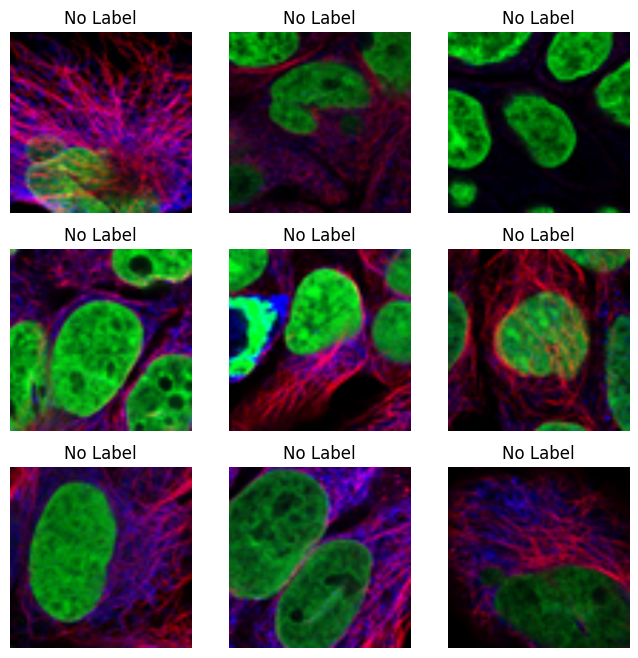

In [16]:
class_to_idx = train_dataset.class_to_idx
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

transform = transforms.Compose([
    transforms.Resize(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
test_dataset = CellsTestDataset(
    img_dir="images_test/", transform=transform)
print(f"Test dataset length: {len(test_dataset)}")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

show_images(test_dataset)

In [17]:
model.eval()
predictions = []
file_ids = []
with torch.no_grad():
    for inputs, file_id in tqdm(test_loader, desc='Predicting'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend([idx_to_class[pred.item()] for pred in preds])
        file_ids.extend(file_id)

df_predictions = pd.DataFrame({'file_id': file_ids, 'cell_line': predictions})
df_predictions.to_csv('predictions_resnet_11.csv', index=False)

Predicting: 100%|██████████| 108/108 [01:01<00:00,  1.77it/s]
